# Modeling Partial Orders

Code accompanying the paper "Statistical Modeling of Top-$k$ Partial Orders" by Amel Awadelkarim and Johan Ugander.

## Packages

In [2]:
# Analysis and Data
import numpy as np
import pandas as pd
import scipy
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import networkx as nx
import collections

# Modeling
import src.stratified_pytorch as sp
import src.data_processing as dp

# Plotting
import seaborn as sns
sns.set_theme(style='whitegrid', rc={'grid.alpha': 0.25, 'text.usetex': False})
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
from shapely import wkt

# Misc
import sys # For library installation
import re # For regex
from glob import glob # For parsing directories
from tqdm import tqdm
import importlib
from joblib import Parallel, delayed

## Import Data

In [13]:
importlib.reload(dp)

<module 'src.data_processing' from '/home/ameloa/partial-orders/src/data_processing.py'>

In [8]:
import os
data_root = 'data/'
paths = [os.path.join(data_root, name) for name in os.listdir(data_root) if name.endswith('.csv')]
elections_df = pd.concat([pd.read_csv(path, low_memory=False) for path in paths], ignore_index=True).drop(columns='Unnamed: 0')
elections_df['year'] = elections_df['year'].map(str)
elections_df.head()

,pref_voter_id,year,race,first_report_seen,vote_rank,candidate
0,0,2019,M,1,"[1, 2]","['LONDON BREED', 'JOEL VENTRESCA']"
1,2,2019,M,1,[1],['LONDON BREED']
2,5,2019,M,1,"[1, 2, 3, 4, 5, 6]","['JOEL VENTRESCA', 'PAUL YBARRA ROBERTSON', 'E..."
3,8,2019,M,1,[1],['LONDON BREED']
4,10,2019,M,1,"[1, 2, 3, 4, 5, 6]","['LONDON BREED', 'PAUL YBARRA ROBERTSON', 'WIL..."


## Repeated selection

Converting ranking objects into choice observations

In [9]:
school_choice_datasets = {}
rcv_datasets = collections.defaultdict(dict)
for year in elections_df.year.unique():
    for race in elections_df.race.unique():
        subset_df = elections_df.query('year==@year & race==@race')
        if not subset_df.empty:
            rcv_datasets[year][race] = dp.sfrcv_clean_dataframe(subset_df)

In [10]:
'''
K-fold cross val for selecting hyperparams
'''
year='2019'
race='M'
dataset = rcv_datasets[year][race]

kfolds=5
shuffled = dataset.sample(frac=1).reset_index(drop=True)
folds = np.array_split(shuffled, kfolds)
dataset = pd.concat(folds)

'''
Convert rankings to choices
'''
choices, agents_codex, alternatives_codex, ballot = dp.prep_dataset(dataset, end_token=False)

num_alternatives = len(alternatives_codex)
num_agents = len(agents_codex)
print('No. agents:\t\t{}'.format(num_agents))
print('No. alternatives:\t{}'.format(num_alternatives))
print('Avg. len of ranking:\t{}'.format(dataset.num_ranked.mean()))
print('No. training examples:\t{}'.format(choices[0].shape[0]))

No. agents:		178924
No. alternatives:	7
Avg. len of ranking:	2.628141377345208
No. training examples:	461186


## Hyperparameter tuning

Model hyperameter selection for the length-dependent composite model and stratified augmented model.

### Length-dependent composite model

In [16]:
def length_strat_sweep(i, length_k, length_reg):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])

    train_choices, train_agent_codex, train_alt_codex, train_ballot = dp.prep_dataset(train)
    (xval, xlval, yval), val_agent_codex = dp.prep_valset(val, train_alt_codex)
    
    num_observations = train_choices[0].shape[0]
    num_agents = len(train_agent_codex)
    num_alternatives = len(train_alt_codex)
    max_length = train_ballot.length.max()
    length_k = min(length_k, max_length)

    kwargs={'mnl_fixed_effects': True,
            'categorical': True,
            'dependent': True,
            'max_length': max_length,
            'length_k': length_k,
            'length_reg': length_reg
           }
    model, tr_loss, no_params, num_epochs, runtime, tr_losses, _ = sp.train(ds=train_choices, 
                                                                            num_items=len(train_alt_codex), 
                                                                            alternative_codex=train_alt_codex, 
                                                                            epochs=2000, 
                                                                            lr=1e-3, 
                                                                            wd=1e-5, 
                                                                            verbose=True, 
                                                                            Model=sp.JointModel,
                                                                            **kwargs)
    task_loss = tr_loss - np.array(tr_losses)[-1, -1]
    result.append(['length dependent', i, length_k, length_reg, 'train', task_loss, num_epochs, runtime, no_params])
    result.append(['length dependent', i, length_k, length_reg, 'train + reg', tr_loss, num_epochs, runtime, no_params])
    
    yval_hat = model.forward(xval, xlval)
    v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xval, xlval, train=False)
    result.append(['length dependent', i, length_k, length_reg, 'val', float(v_loss), num_epochs, runtime, no_params])
    return result

In [ ]:
length_ks = [1,2,3,5,10,15]
length_regs = [0.0, 1e-3, 1e-2, 0.1]

strat_results = Parallel(n_jobs=30)(delayed(length_strat_sweep)(i, length_k, length_reg) 
                                    for i in range(kfolds) 
                                    for length_k in length_ks
                                    for length_reg in length_regs)
strat_results = [item for sublist in strat_results for item in sublist]
strat_results_df = pd.DataFrame(strat_results, columns=['model', 'fold', 'length k', 'length reg', 'loss type', 'loss', 'num epochs', 'runtime', 'no params'])

/home/ameloa/partial-orders/src/stratified_pytorch.py:549: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
/home/ameloa/partial-orders/src/stratified_pytorch.py:549: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
/home/ameloa/partial-orders/src/stratified_pytorch.py:549: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
<class 'networkx.utils.d

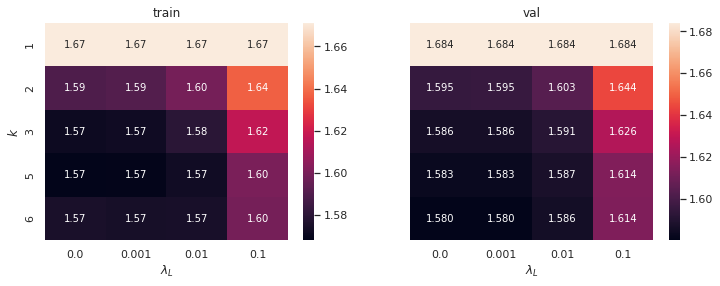

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12, 4), sharey=True)
pt_dependent = pd.pivot_table(strat_results_df[strat_results_df['loss type']=='train'], values='loss', index='length k', columns='length reg')
sns.heatmap(pt_dependent, annot=True, fmt='.2f', ax=ax[0]).set(title='train', ylabel=r'$k$', xlabel=r'$\lambda_L$')

pt_dependent = pd.pivot_table(strat_results_df[strat_results_df['loss type']=='val'], values='loss', index='length k', columns='length reg')
sns.heatmap(pt_dependent, annot=True, fmt='.3f', ax=ax[1]).set(title='val', ylabel='', xlabel=r'$\lambda_L$')
plt.show()

### Stratified augmented model

In [22]:
def mnl_strat_sweep(i, mnl_k, rank_reg):
    result=[]
    val = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])

    train_choices, train_agent_codex, train_alt_codex, train_ballot = dp.prep_dataset(train)
    (xval, xlval, yval), val_agent_codex = dp.prep_valset(val, train_alt_codex)

    kwargs={'mnl_fixed_effects': True,
            'position_dependent_end': False,
            'mnl_k': mnl_k,
            'rank_reg': rank_reg
           }
    model, tr_loss, no_params, num_epochs, runtime, tr_losses, _ = sp.train(ds=train_choices, 
                                                                            num_items=len(train_alt_codex), 
                                                                            alternative_codex=train_alt_codex, 
                                                                            epochs=2000, 
                                                                            lr=1e-3, 
                                                                            wd=1e-5, 
                                                                            verbose=True, 
                                                                            Model=sp.ENDModel,
                                                                            **kwargs)
    task_loss = tr_loss - np.array(tr_losses)[-1, -1]
    result.append(['stratified augmented', i, mnl_k, rank_reg, 'train', task_loss, num_epochs, runtime, no_params])
    result.append(['stratified augmented', i, mnl_k, rank_reg, 'train + reg', tr_loss, num_epochs, runtime, no_params])
    
    yval_hat = model.forward(xval, xlval)
    v_loss, v_loss_terms = model.loss_func(yval_hat, yval, xval, xlval, train=False)
    result.append(['stratified augmented', i, mnl_k, rank_reg, 'val', float(v_loss), num_epochs, runtime, no_params])
    return result

In [27]:
mnl_ks = [1,2,3,5,10,15]
rank_regs = [0.0, 1e-3, 1e-2, 0.1]

aug_strat_results = Parallel(n_jobs=30)(delayed(mnl_strat_sweep)(i, mnl_k, rank_reg) 
                                        for i in range(kfolds)
                                        for mnl_k in mnl_ks
                                        for rank_reg in rank_regs)
aug_strat_results = [item for sublist in aug_strat_results for item in sublist]
aug_strat_results_df = pd.DataFrame(aug_strat_results, columns=['model', 'fold', 'mnl k', 'rank reg', 'loss type', 'loss', 'num epochs', 'runtime', 'no params'])

ValueError: zero-size array to reduction operation fmin which has no identity

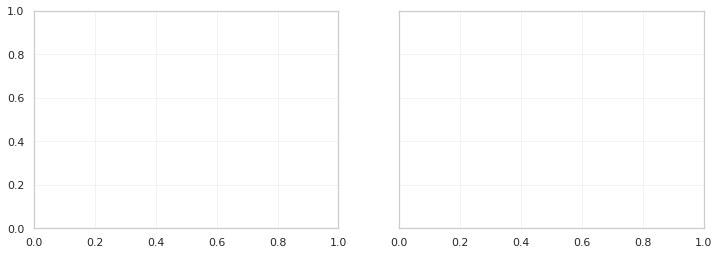

No. params:  16
Runtime: 50.11660432815552
Loss: inf
No. params:  120
Runtime: 155.6008186340332
Loss: inf
No. params:  80
Runtime: 106.24712991714478
Loss: inf
No. params:  24
Runtime: 59.33014154434204
Loss: inf
No. params:  120
Runtime: 155.60270142555237
Loss: inf
No. params:  80
Runtime: 106.24724841117859
Loss: inf
No. params:  120
Runtime: 123.3924446105957
Loss: inf
No. params:  24
Runtime: 43.4481258392334
Loss: inf
No. params:  16
Runtime: 43.35482835769653
Loss: inf
No. params:  8
Runtime: 38.35065269470215
Loss: inf
No. params:  80
Runtime: 89.85568952560425
Loss: inf
No. params:  16
Runtime: 38.29476451873779
Loss: inf
No. params:  80
Runtime: 91.59365391731262
Loss: inf
No. params:  8
Runtime: 37.347628116607666
Loss: inf
No. params:  8
Runtime: 38.696531534194946
Loss: inf
No. params:  40
Runtime: 88.03870868682861
Loss: inf
No. params:  8
Runtime: 29.189850568771362
Loss: inf
No. params:  8
Runtime: 27.990496397018433
Loss: inf
No. params:  16
Runtime: 51.92961382865906

In [28]:
fig, ax = plt.subplots(1,2,figsize=(12, 4), sharey=True)
pt_dependent = pd.pivot_table(aug_strat_results_df[aug_strat_results_df['loss type']=='train'], values='loss', index='mnl k', columns='rank reg')
sns.heatmap(pt_dependent, annot=True, fmt='.2f', ax=ax[0]).set(title='train', ylabel=r'$k$', xlabel=r'$\lambda_L$')

pt_dependent = pd.pivot_table(aug_strat_results_df[aug_strat_results_df['loss type']=='val'], values='loss', index='mnl k', columns='rank reg')
sns.heatmap(pt_dependent, annot=True, fmt='.3f', ax=ax[1]).set(title='val', ylabel='', xlabel=r'$\lambda_L$')
plt.show()

## Training

In [29]:
def kfold_train_test(i, model_name, length_k, length_reg, mnl_k, rank_reg, dataset_name, dataset, mnl_covariates=None, length_covariates=None, num_ranks=0):
    if (model_name == 'conditionally independent') & (mnl_covariates == None):
        return
    
    shuffled = dataset.sample(frac=1,random_state=0).reset_index(drop=True)
    folds = np.array_split(shuffled, kfolds)
    
    result=[]
    test = folds[i]
    train = pd.concat([df for j, df in enumerate(folds) if j!=i])

    train_choices, train_agent_codex, train_alt_codex, train_school_codex, train_program_to_school, train_program_type_codex, train_program_to_type, train_ctip_codex, train_ballot = dp.prep_dataset(train, school_choice=school_choice, program_data=program_data)
    num_observations = train_choices[0].shape[0]
    num_agents = len(train_agent_codex)
    num_alternatives = len(train_alt_codex)
    max_length = train_ballot.length.max()
    length_k = min(length_k, max_length)
    mnl_k = min(mnl_k, max_length)
        
    (xtest, xltest, ytest), test_agent_codex, test_ctip_codex = dp.prep_valset(test, train_alt_codex)
    if mnl_covariates:
        '''
        RCV data has no covariates, so this condition is a placeholder. 
        If your dataset includes agent/alternative + agent covariates, 
           pass those along as mnl_covariates + length_covariates pandas dataframes.
        '''
        mnl_covariates_train = mnl_covariates.loc[train_agent_codex, train_alt_codex]
        poisson_covariates_train = length_covariates.loc[train_agent_codex].values.astype(np.float32)
        mnl_covariates_test = mnl_covariates.loc[test_agent_codex, train_alt_codex]
        poisson_covariates_test = length_covariates.loc[test_agent_codex].values.astype(np.float32)
    else: 
        mnl_covariates_train, poisson_covariates_train, mnl_covariates_test, poisson_covariates_test = None, None, None, None
    
    kwargs={'mnl_fixed_effects': True,
            'max_length': max_length
            'mnl_covariates': mnl_covariates
           }
    if model_name == 'length dependent':
        kwargs['categorical'] = True
        kwargs['dependent'] = True
        kwargs['length_k'] = length_k
        kwargs['length_reg'] = length_reg
    elif model_name == 'fully independent':
        kwargs['categorical'] = True
        kwargs['dependent'] = False
    elif model_name == 'conditionally independent':
        kwargs['dependent'] = False
        kwargs['poisson_covariates'] = poisson_covariates_train
    elif model_name == 'augmented':
        kwargs['position_dependent_end'] = False
    elif model_name == 'stratified augmented':
        kwargs['position_dependent_end'] = False
        kwargs['mnl_k'] = mnl_k
        kwargs['rank_reg'] = rank_reg
    else:
        pass
    model, tr_loss, no_params, num_epochs, runtime, tr_losses, _ = sp.train(ds=train_choices, 
                                                                            num_items=len(train_alt_codex), 
                                                                            alternative_codex=train_alt_codex,
                                                                            epochs=2000, 
                                                                            lr=1e-3, 
                                                                            wd=1e-5, 
                                                                            verbose=True, 
                                                                            Model=sp.JointModel if 'augmented' not in model_name else sp.ENDModel,
                                                                            **kwargs)
    tr_losses = np.array(tr_losses)
    task_loss = tr_loss - tr_losses[-1, -1]
    result.append([i, dataset_name, school_choice, model_name, 'train', 'overall', num_agents, num_alternatives, num_observations, float(task_loss), num_epochs, runtime, no_params])
    result.append([i, dataset_name, school_choice, model_name, 'train + reg', 'overall', num_agents, num_alternatives, num_observations, float(tr_loss), num_epochs, runtime, no_params])

    ytest_hat = model.forward(xtest, xltest, poisson_covariates=poisson_covariates_test, mnl_covariates=mnl_covariates_test) if model_name == 'conditionally independent' else model.forward(xtest, xltest, mnl_covariates=mnl_covariates_test)
    test_loss, test_loss_terms = model.loss_func(ytest_hat, ytest, xtest, xltest, mnl_covariates=mnl_covariates_test, poisson_covariates=poisson_covariates_test, train=False) if model_name == 'conditionally independent' else model.loss_func(ytest_hat, ytest, xtest, xltest, mnl_covariates=mnl_covariates_test, train=False)
    result.append([i, dataset_name, school_choice, model_name, 'test', 'overall', num_agents, num_alternatives, num_observations, float(test_loss), num_epochs, runtime, no_params])
    for i, loss_type in enumerate(['choice', 'length', 'reg']):
        result.append([i, dataset_name, school_choice, model_name, 'train', num_agents, num_alternatives, num_observations, loss_type, float(tr_losses[-1, i]), num_epochs, runtime, no_params])
        result.append([i, dataset_name, school_choice, model_name, 'test', num_agents, num_alternatives, num_observations, loss_type, float(test_loss_terms[i]), num_epochs, runtime, no_params])
    return result

In [30]:
def full_train(model_name, length_k, length_reg, mnl_k, rank_reg, dataset_name, dataset, school_choice=False, program_data=None, num_ranks=0):
    if (model_name == 'conditionally independent') & (not school_choice):
        return
    
    shuffled = dataset.sample(frac=1,random_state=0).reset_index(drop=True)
    train = shuffled

    train_choices, train_agent_codex, train_alt_codex, train_school_codex, train_program_to_school, train_program_type_codex, train_program_to_type, train_ctip_codex, train_ballot = dp.prep_dataset(train, school_choice=school_choice, program_data=program_data)
    num_observations = train_choices[0].shape[0]
    num_agents = len(train_agent_codex)
    num_alternatives = len(train_alt_codex)
    max_length = train_ballot.length.max()
    print("Dataset: {}\tn: {}\tm: {}\tN: {}\tAvg. len: {}\tMax len: {}".format(dataset_name, num_agents, num_alternatives, num_observations, num_observations/float(num_agents), max_length))

    if school_choice:
        mnl_covariates_train = generate_covariate_matrix(program_attributes_test, train_agent_codex, train_alt_codex, train_ctip_codex)
        poisson_covariates_train = household_covariates.loc[train_agent_codex].values.astype(np.float32)
    else: 
        mnl_covariates_train, poisson_covariates_train = None, None
    
    kwargs={'mnl_fixed_effects': True,
            'school_choice': school_choice,
            'item_to_school': train_program_to_school,
            'item_to_program': train_program_to_type,
            'school_names': train_school_codex,
            'program_type_names': train_program_type_codex,
            'mnl_linear_terms': school_choice,
            'mnl_covariates': mnl_covariates_train,
            'max_length': max_length
           }
    if model_name == 'length dependent':
        kwargs['categorical'] = True
        kwargs['dependent'] = True
        kwargs['length_k'] = length_k
        kwargs['length_reg'] = length_reg
    elif model_name == 'fully independent':
        kwargs['categorical'] = True
        kwargs['dependent'] = False
    elif model_name == 'conditionally independent':
        kwargs['dependent'] = False
        kwargs['poisson_covariates'] = poisson_covariates_train
    elif model_name == 'augmented':
        kwargs['position_dependent_end'] = False
    elif model_name == 'stratified augmented':
        kwargs['mnl_k'] = mnl_k
        kwargs['rank_reg'] = rank_reg
    else:
        pass
    model, tr_loss, no_params, num_epochs, runtime, tr_losses, _ = sp.train(ds=train_choices, 
                                                                            num_items=len(train_alt_codex),
                                                                            alternative_codex=train_alt_codex,
                                                                            epochs=2000, 
                                                                            lr=1e-3, 
                                                                            wd=1e-5, 
                                                                            verbose=True, 
                                                                            Model=sp.JointModel if 'augmented' not in model_name else sp.ENDModel,
                                                                            **kwargs)
    return (dataset_name, model_name, model)

In [31]:
school_choice_indicators = []
length_ks = []
length_regs = []
mnl_ks = []
rank_regs = []
dataset_names = []
datasets = []
program_datasets = []
for year, dictionary in rcv_datasets.items():
    for race, dataset in dictionary.items():
        school_choice_indicators.append(False)
        length_ks.append(10)
        length_regs.append(0.0)
        mnl_ks.append(10)
        rank_regs.append(0.0)
        dataset_names.append('{} {}'.format(year, race))
        datasets.append(dataset)
        program_datasets.append(None)

In [ ]:
importlib.reload(sp)
model_names=['fully independent', 'conditionally independent', 'length dependent', 'augmented', 'position-dependent augmented', 'stratified augmented']
kfolds=5
kfold_results = Parallel(n_jobs=30)(delayed(kfold_train_test)(i, model_name, length_k, length_reg, mnl_k, rank_reg, dataset_name, 
                                                                  dataset, program_data=data, school_choice=school_choice) 
                                      for i in range(kfolds)
                                      for model_name in model_names
                                      for dataset_name, dataset, school_choice, data, length_k, length_reg, mnl_k, rank_reg in zip(dataset_names, 
                                                                                                                                   datasets, 
                                                                                                                                   school_choice_indicators, 
                                                                                                                                   program_datasets, 
                                                                                                                                   length_ks, 
                                                                                                                                   length_regs, 
                                                                                                                                   mnl_ks, 
                                                                                                                                   rank_regs))

/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:550: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:550: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:550: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in

In [49]:
kfold_train_df = pd.DataFrame([subitem for result in kfold_results if result is not None for subitem in result],
                             columns=['i', 'dataset', 'school choice', 'model name', 'loss type', 'term', 'n', 'm', 'num_obs', 'loss', 'num epochs', 'runtime', 'no params'])
full_results = kfold_train_df[(kfold_train_df['loss type']!='train + reg')&(kfold_train_df['term']!='reg')]
overall_results = kfold_train_df[(kfold_train_df['term']=='overall') & (kfold_train_df['loss type']!='train + reg')]
overall_results['dataset label'] = overall_results['dataset'].map({'2018 BOS': 'RCV1',
                                                                   '2019 DA': 'RCV2',
                                                                   '2019 BOS': 'RCV3',
                                                                   '2019 M': 'RCV4',
                                                                   '2018 M': 'RCV5',
                                                                   '1819 SFUSD': 'SC1',
                                                                   '1718 SFUSD': 'SC2'})
overall_results['Model'] = overall_results['model name'].map({'fully independent': 'C-I',
                                                              'conditionally independent': 'C-CI',
                                                              'length dependent': 'C-LD',
                                                              'augmented': 'A',
                                                              'position-dependent augmented': 'A-PD',
                                                              'stratified augmented': 'A-S'})
overall_results['model category'] = overall_results['model name'].map({'fully independent': 'composite',
                                                                       'conditionally independent': 'composite',
                                                                       'length dependent': 'composite',
                                                                       'augmented': 'augmented',
                                                                       'position-dependent augmented': 'augmented',
                                                                       'stratified augmented': 'augmented'})

/tmp/ipykernel_860476/1188411687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_results['dataset label'] = overall_results['dataset'].map({'2018 BOS': 'RCV1',
/tmp/ipykernel_860476/1188411687.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_results['Model'] = overall_results['model name'].map({'fully independent': 'C-I',
/tmp/ipykernel_860476/1188411687.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

NameError: name 'overall_results' is not defined

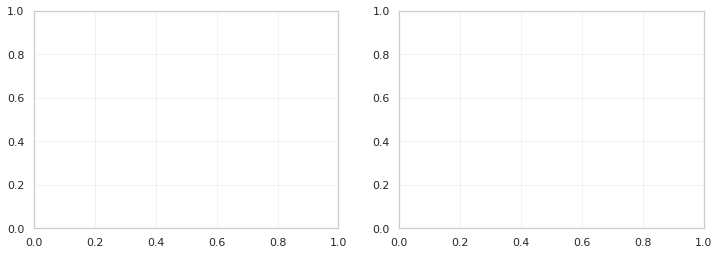

In [60]:
model_names = ['fully independent', 'conditionally independent', 'length dependent', 'augmented', 'position-dependent augmented', 'stratified augmented']
hue_order = ['C-I', 'C-CI', 'C-LD', 'A', 'A-PD', 'A-S']
palette = sns.color_palette("Blues", n_colors=3)+sns.color_palette("YlOrBr", n_colors=3)
fig, ax = plt.subplots(1,2,figsize=(12,4))

data = overall_results[overall_results['loss type']=='test']
data = data.assign(num_alternatives=data['dataset'].map({'2018 BOS': 3, 
                                                         '2018 M': 8, 
                                                         '2019 DA': 4, 
                                                         '2019 M': 7, 
                                                         '2019 BOS': 4, 
                                                         '1718 SFUSD': 152, 
                                                         '1819 SFUSD': 152})).sort_values(by='num_alternatives')

# data = data[data.Model=='A']
sns.pointplot(data=data, x='dataset label', y='loss', hue='Model', markers=['o','o','o','x','x', 'x'],
              hue_order=hue_order, palette=palette, dodge=True, join=False, alpha=0.5, ax=ax[0]).set(xlabel='Dataset',
                                                                                                  ylabel='NLL')
sns.pointplot(data=data, x='dataset label', y='runtime', hue='Model', markers=['o','o','o','x','x','x'], 
              hue_order=hue_order, palette=palette, dodge=True, join=False, alpha=0.5, ax=ax[1]).set(xlabel='Dataset',
                                                                                                     ylabel='Runtime (s)')

ax[1].legend().remove()
# ax[0].set_ylim(0.0, 6.0)
# ax.set_xticks(ticks=np.arange(7), labels=['RCV1', 'RCV2', 'RCV3', 'RCV4', 'RCV5', 'SC1', 'SC2'])
# ax[1].set_xticks(ticks=np.arange(7), labels=['RCV1', 'RCV2', 'RCV3', 'RCV4', 'RCV5', 'SC1', 'SC2'])
# ax[1].set_ylim(-500, 8000)
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'right'})
# ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'right'})
fig.tight_layout()

In [32]:
model_names=['fully independent', 'conditionally independent', 'length dependent', 'augmented', 'position-dependent augmented', 'stratified augmented']
full_train_results = Parallel(n_jobs=30)(delayed(full_train)(model_name, length_k, length_reg, mnl_k, rank_reg, dataset_name, 
                                                        dataset, program_data=data, school_choice=school_choice) 
                                         for model_name in model_names
                                         for dataset_name, dataset, school_choice, data, length_k, length_reg, mnl_k, rank_reg in zip(dataset_names, 
                                                                                                                                      datasets, 
                                                                                                                                      school_choice_indicators, 
                                                                                                                                      program_datasets, 
                                                                                                                                      length_ks, 
                                                                                                                                      length_regs, 
                                                                                                                                      mnl_ks, 
                                                                                                                                      rank_regs))

/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:552: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:552: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:552: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_likelihoods = F.log_softmax(self.length_logits.weight.flatten())[x_extra[:,4]-1]
<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in

Dataset: 2018 BOS	n: 33394	m: 3	N: 68148	Avg. len: 2.0407258789004015	Max len: 3
No. params:  4
Epoch: 25, Training Loss: 1.2619116306304932
Epoch: 50, Training Loss: 1.165297508239746
Epoch: 75, Training Loss: 1.1267025470733643
Epoch: 100, Training Loss: 1.110558032989502
Epoch: 125, Training Loss: 1.1032156944274902
Epoch: 150, Training Loss: 1.0994294881820679
Runtime: 269.8835542201996
Loss: 1.098697304725647
Dataset: 2018 BOS	n: 33394	m: 3	N: 68148	Avg. len: 2.0407258789004015	Max len: 3
No. params:  6
Epoch: 25, Training Loss: 1.2481828927993774
Epoch: 50, Training Loss: 1.1274986267089844
Epoch: 75, Training Loss: 1.0789717435836792
Epoch: 100, Training Loss: 1.0580235719680786
Epoch: 125, Training Loss: 1.048182487487793
Epoch: 150, Training Loss: 1.0431214570999146
Runtime: 299.0474977493286
Loss: 1.0408354997634888
Dataset: 2019 DA	n: 193492	m: 4	N: 448815	Avg. len: 2.3195532631840075	Max len: 4
No. params:  20
Runtime: 127.58096885681152
Loss: 1.5189459323883057
Dataset: 18

In [33]:
model_dict = collections.defaultdict(dict)
for model_tuple in full_train_results:
    if model_tuple:
        model_dict[model_tuple[0]][model_tuple[1]] = model_tuple[2]

Dataset: 2018 BOS	n: 33394	m: 3	N: 68148	Avg. len: 2.0407258789004015	Max len: 3
No. params:  12
Epoch: 25, Training Loss: 1.0251072645187378
Epoch: 50, Training Loss: 1.0102695226669312
Runtime: 261.86625385284424
Loss: 1.0085591077804565
Dataset: 1819 SFUSD	n: 3544	m: 152	N: 35333	Avg. len: 9.969808126410836	Max len: 85
No. params:  1570
Epoch: 25, Training Loss: 4.255235195159912
Epoch: 50, Training Loss: 3.9635627269744873
Epoch: 75, Training Loss: 3.8344714641571045
Epoch: 100, Training Loss: 3.761658191680908
Epoch: 125, Training Loss: 3.7163150310516357
Epoch: 150, Training Loss: 3.686614990234375
Epoch: 175, Training Loss: 3.6666111946105957
Epoch: 200, Training Loss: 3.652794599533081
Epoch: 225, Training Loss: 3.642929792404175
Epoch: 250, Training Loss: 3.6355860233306885
Epoch: 275, Training Loss: 3.629882335662842
Epoch: 300, Training Loss: 3.6252880096435547
Epoch: 325, Training Loss: 3.6214802265167236
Epoch: 350, Training Loss: 3.6182541847229004
Epoch: 375, Training Lo

## Evaluation

### Generate preferences / modal lengths

In [34]:
def sample_datasets(i, dataset, dataset_name, model_name, model):
    random.seed(model_name+str(i))
    length_results = []
    length_summary = []
    demand_results=[]
    true_lengths = dataset.num_ranked.values
    num_agents = true_lengths.size
    if (model_name == 'conditionally independent') and model.school_choice:
        sampled_lengths, sampled_prefs = model.sample_preferences()
    else:
        num_agents = num_agents if model.mnl_covariates is None else model.mnl_covariates.shape[0]
        sampled_lengths, sampled_prefs = model.sample_preferences(num_samples=num_agents)
    length_summary.append([i, dataset_name, model_name, num_agents, model.num_items, model.numel(), 'length', 'mean', sampled_lengths.mean()])
    length_summary.append([i, dataset_name, model_name, num_agents, model.num_items, model.numel(), 'length', 'median', np.median(sampled_lengths)])
    length_summary.append([i, dataset_name, model_name, num_agents, model.num_items, model.numel(), 'length', 'mode', scipy.stats.mode(sampled_lengths).mode[0]])
    length_summary.append([i, dataset_name, model_name, num_agents, model.num_items, model.numel(), 'length', 'std', sampled_lengths.std()])

    # hist, bin_edges = np.histogram(sampled_lengths, bins=model.num_items, range=(1,model.num_items+1))
    # length_results.extend([[i, dataset_name, model_name, histval, binval] for histval, binval in zip(hist, bin_edges[:-1])])
    length_results.extend([[i, dataset_name, model_name, length] for length in sampled_lengths])

    sampled_candidates = np.array(model.alternative_codex)[sampled_prefs[sampled_prefs<(model.num_items+1)]]
    candidates, counts = np.unique(sampled_candidates, return_counts=True)
    for candidate, proportion in zip(candidates, counts/counts.sum()):
        demand_results.append([i, dataset_name, model_name, num_agents, model.num_items, model.numel(), 'overall candidate', candidate, proportion])
    sampled_candidates = np.array(model.alternative_codex)[sampled_prefs[:,0]]
    candidates, counts = np.unique(sampled_candidates, return_counts=True)
    for candidate, proportion in zip(candidates, counts/counts.sum()):
        demand_results.append([i, dataset_name, model_name, num_agents, model.num_items, model.numel(), 'top-1 candidate', candidate, proportion])
    return length_results, length_summary+demand_results

In [35]:
true_demand_results = []
true_length_results = []
for dataset_name, dataset in zip(dataset_names, datasets):
    print(dataset_name)
    model = model_dict[dataset_name]['fully independent']
    true_lengths = dataset.num_ranked.values
    num_agents = true_lengths.size
    true_demand_results.extend([[0, dataset_name, 'true', num_agents, model.num_items, 0, 'length', 'mean', true_lengths.mean()], 
                                [0, dataset_name, 'true', num_agents, model.num_items, 0, 'length', 'median', np.median(true_lengths)], 
                                [0, dataset_name, 'true', num_agents, model.num_items, 0, 'length', 'mode', scipy.stats.mode(true_lengths).mode[0]], 
                                [0, dataset_name, 'true', num_agents, model.num_items, 0, 'length', 'std', true_lengths.std()]])
    
    true_length_results.extend([[0, dataset_name, 'true', length] for length in true_lengths])

    candidates, counts = np.unique(dataset.alternatives.explode().values, return_counts=True)
    for candidate, proportion in zip(candidates, counts/counts.sum()):
        true_demand_results.append([0, dataset_name, 'true', num_agents, model.num_items, 0, 'overall candidate', candidate, proportion])
    top1_candidates = [candidate_list[0] for candidate_list in dataset.alternatives]
    candidates_top1, counts = np.unique(top1_candidates, return_counts=True)
    for candidate, proportion in zip(candidates_top1, counts/counts.sum()):
        true_demand_results.append([0, dataset_name, 'true', num_agents, model.num_items, 0, 'top-1 candidate', candidate, proportion])


2019 M
2019 BOS
2019 DA
2018 M
2018 BOS
1718 SFUSD
1819 SFUSD


In [36]:
sampling_results = Parallel(n_jobs=30)(delayed(sample_datasets)(i, school_choice_datasets[dataset_name.split()[0]] if 'SFUSD' in dataset_name else rcv_datasets[dataset_name.split()[0]][dataset_name.split()[1]], 
                                                                dataset_name, 
                                                                model_name, 
                                                                model) 
                                       for i in range(100)
                                       for dataset_name, dictionary in model_dict.items()
                                       for model_name, model in dictionary.items())

/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:1145: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  covariates = t.from_numpy(covariates)
/home/ameloa/school_choice_project/arjun_cdm/stratified_pytorch.py:1145: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tenso

In [37]:
results = true_demand_results + [subitem for _, item in sampling_results for subitem in item]
sampling_df = pd.DataFrame(results, columns=['i', 'dataset', 'model name', 'n', 'm', 'no_params', 'metric_type', 'metric', 'value'])
sampling_df['model category'] = sampling_df['model name'].map({'fully independent': 'composite',
                                                               'conditionally independent': 'composite',
                                                               'length dependent': 'composite',
                                                               'augmented': 'augmented',
                                                               'position-dependent augmented': 'augmented',
                                                               'stratified augmented': 'augmented'})
sampling_df['dataset label'] = sampling_df['dataset'].map({'2018 BOS': 'RCV1',
                                                           '2019 DA': 'RCV2',
                                                           '2019 BOS': 'RCV3',
                                                           '2019 M': 'RCV4',
                                                           '2018 M': 'RCV5'})
sampling_df['name label'] = sampling_df['model name'].map({'true': 'true', 
                                                           'fully independent': 'C-I',
                                                           'conditionally independent': 'C-CI',
                                                           'length dependent': 'C-LD',
                                                           'augmented': 'A',
                                                           'position-dependent augmented': 'A-PD',
                                                           'stratified augmented': 'A-S'})
sampling_df['display name'] = sampling_df['metric'].apply(lambda x: x.replace(' ', '\n'))

In [38]:
length_results = true_length_results.copy()
[length_results.extend(item) for item, _ in sampling_results]
length_df = pd.DataFrame(length_results, columns=['i', 'dataset', 'model_name', 'Length'])
length_df['Model'] = length_df['model_name'].map({'true': 'true', 
                                                  'fully independent': 'C-I',
                                                  'conditionally independent': 'C-CI',
                                                  'length dependent': 'C-LD',
                                                  'augmented': 'A',
                                                  'position-dependent augmented': 'A-PD',
                                                  'stratified augmented': 'A-S'})

In [39]:
length_df.head(25)

,i,dataset,model_name,Length,Model,school_choice
0,0,2019 M,true,2,true,False
1,0,2019 M,true,1,true,False
2,0,2019 M,true,6,true,False
3,0,2019 M,true,1,true,False
4,0,2019 M,true,6,true,False
5,0,2019 M,true,6,true,False
6,0,2019 M,true,1,true,False
7,0,2019 M,true,1,true,False
8,0,2019 M,true,1,true,False
9,0,2019 M,true,1,true,False


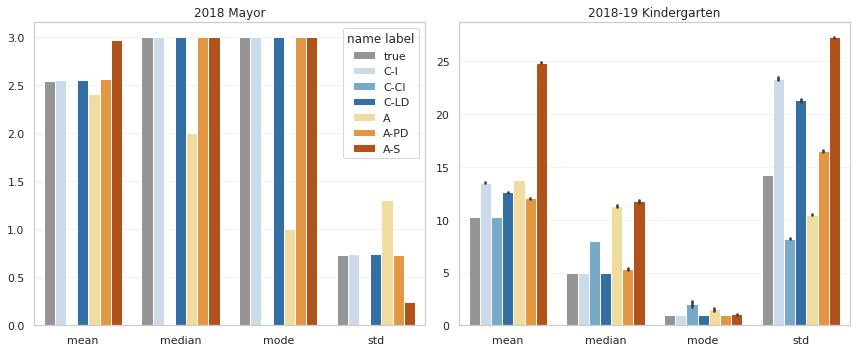

In [64]:
names = ['2018 M']
display_names = ['2018 Mayor']
hue_order = ['true', 'C-I', 'C-CI', 'C-LD', 'A', 'A-PD', 'A-S']
model_names=['true', 'fully independent', 'conditionally independent', 'length dependent', 'augmented', 'position-dependent augmented', 'stratified augmented']
palette = sns.color_palette('Greys', n_colors=1) + sns.color_palette("Blues", n_colors=3)+sns.color_palette("YlOrBr", n_colors=3)

fig, ax = plt.subplots(1,len(names), figsize=(12,5))
for i, (dataset, name) in enumerate(zip(names, display_names)):
    data = sampling_df[(sampling_df.metric_type=='length')&
                       (sampling_df.dataset==dataset)]
    sns.barplot(data=data, x="metric", y="value", hue="name label", palette=palette, hue_order=hue_order, ax=ax[i]).set(title=name, xlabel='', ylabel='')
# ax[1].legend().remove()
# ax[1].legend(loc=(1.03,0.52))
fig.tight_layout()

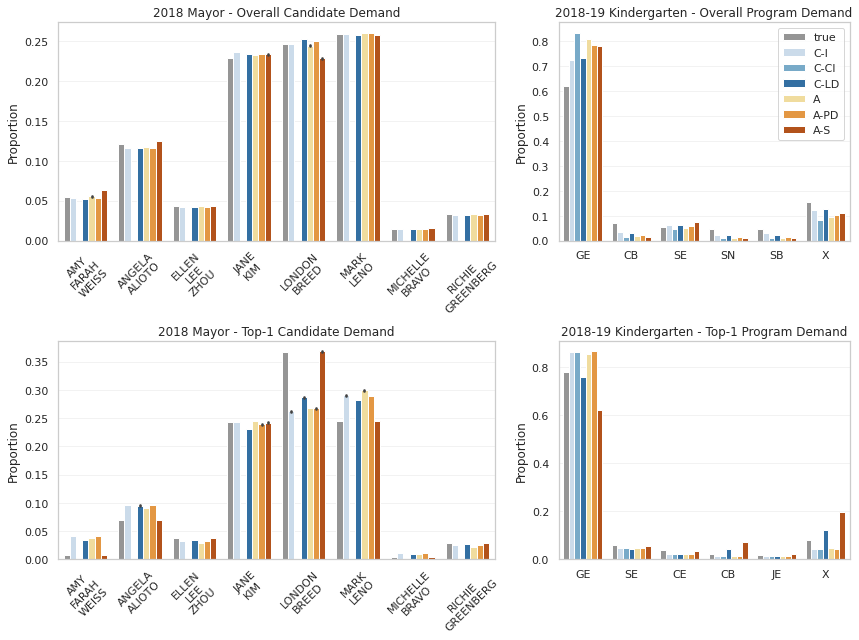

In [77]:
hue_order = ['true', 'C-I', 'C-CI', 'C-LD', 'A', 'A-PD', 'A-S']
palette = sns.color_palette('Greys', n_colors=1) + sns.color_palette("Blues", n_colors=3)+sns.color_palette("YlOrBr", n_colors=3)

fig, ax = plt.subplots(1,2, figsize=(12,5))
name = '2018 Mayor'
dataset = '2018 M'
data = sampling_df[(sampling_df.dataset==dataset)&
                   (sampling_df.metric_type=='overall candidate')&
                   ~(sampling_df['name label'].isin(['C-CI']))]
sns.barplot(data=data, x="display name", y="value", hue="name label",
            palette=palette[:2]+palette[-5:], hue_order=hue_order, ax=ax[0]).set(title='{} - Overall Candidate Demand'.format(name), 
                                                                xlabel='', 
                                                                ylabel='Proportion')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'center'})
data = sampling_df[(sampling_df.dataset==dataset)&
                   (sampling_df.metric_type=='top-1 candidate')&
                   ~(sampling_df['name label'].isin(['C-CI']))]
sns.barplot(data=data, x="display name", y="value", hue="name label",
            palette=palette[:2]+palette[-5:], hue_order=hue_order, ax=ax[1]).set(title='{} - Top-1 Candidate Demand'.format(name),
                                                                xlabel='', 
                                                                ylabel='Proportion')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, fontdict={'horizontalalignment':'center'})

ax[0].legend().remove()
ax[1].legend(loc='upper right')
fig.tight_layout()